<a href="https://colab.research.google.com/github/g-tumwesigye/water_quality_model_assignment/blob/Jules_branch/Water_Quality_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

In [16]:
#import data
path = "/content/water_potability.csv"
data = pd.read_csv(path)

data.head(10)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,NaN,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.508491,9.077200,404.041635,563.885481,17.927806,71.976601,4.370562,0


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


## Data Preprocessing

# Handle missing values


In [18]:
data.fillna(data.mean(), inplace=True)


# Split features (X) and target (Y)


In [19]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

In [20]:
# 📌 Check for class imbalance
print("Class distribution:\n", Y.value_counts())

Class distribution:
 Potability
0    1998
1    1278
Name: count, dtype: int64


In [21]:
# 📌 Compute class weights to handle imbalance

classes = np.unique(Y)  # Get unique classes [0, 1]
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=Y)

# Convert to dictionary format for TensorFlow/Keras
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("Computed Class Weights:", class_weight_dict)


Computed Class Weights: {0: 0.8198198198198198, 1: 1.2816901408450705}


# Scale features using StandardScaler


In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Split data into training, validation, and test sets


In [23]:
# Step 1: Split into 60% training and 40% temporary (validation + test)
X_train, X_temp, Y_train, Y_temp = train_test_split(X_scaled, Y, test_size=0.40, random_state=42)

# Step 2: Split the 40% temporary set
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.50, random_state=42)

# Print dataset sizes
print(f"Training data: {X_train.shape[0]} samples")  # 60% of data
print(f"Validation data: {X_val.shape[0]} samples")  # 20% of data
print(f"Testing data: {X_test.shape[0]} samples")    # 20% of data


Training data: 1965 samples
Validation data: 655 samples
Testing data: 656 samples


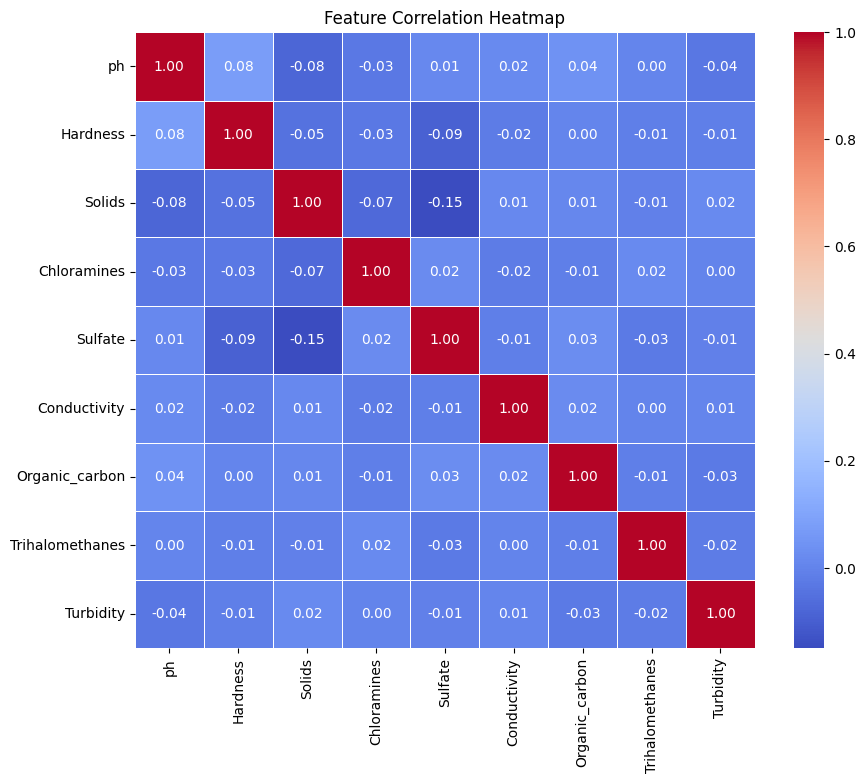

In [24]:
# Feature Correlation Heatmap

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(X, columns=data.drop(columns=["Potability"]).columns).corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [25]:
print(Y.value_counts())  # Check class distribution

Potability
0    1998
1    1278
Name: count, dtype: int64


## Model Architecture

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

In [75]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.0002),
                          kernel_initializer='he_normal', input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.0002),
                          kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.0002),
                          kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.1),  # Reduced dropout for better learning retention
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [76]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
# Adam optimizer with learning rate 0.0002
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# Set EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [77]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)

# Properly map class weights
class_weight_dict = {0: class_weights[0], 1: class_weights[1] * 1.1}

# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=120,
    batch_size=128,
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5394 - loss: 1.1012 - val_accuracy: 0.5847 - val_loss: 0.8802
Epoch 2/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5546 - loss: 0.9457 - val_accuracy: 0.5542 - val_loss: 0.8255
Epoch 3/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5668 - loss: 0.9034 - val_accuracy: 0.5405 - val_loss: 0.8015
Epoch 4/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5635 - loss: 0.8785 - val_accuracy: 0.5450 - val_loss: 0.7912
Epoch 5/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5389 - loss: 0.8672 - val_accuracy: 0.5618 - val_loss: 0.7877
Epoch 6/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5816 - loss: 0.8092 - val_accuracy: 0.5649 - val_loss: 0.7804
Epoch 7/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5884 - loss: 0.8239 - val_accuracy: 0.5756 - val_loss: 0.7768
Epoch 8/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5977 - loss: 0.8045 - val_accuracy: 0.5771 

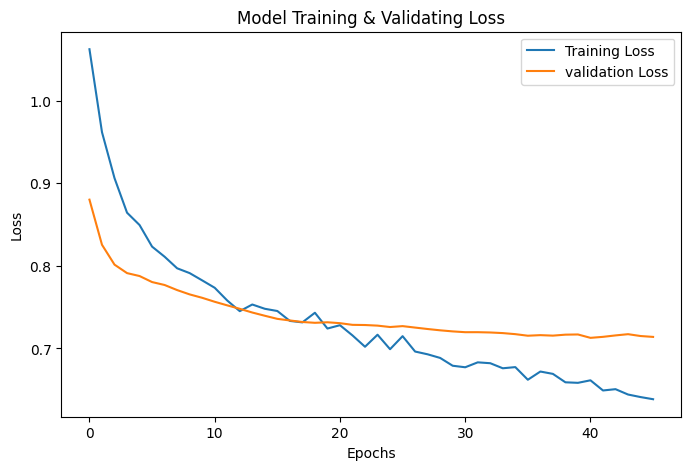

In [78]:
# Training History: Loss over Epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Training & Validating Loss")
plt.legend()
plt.show()


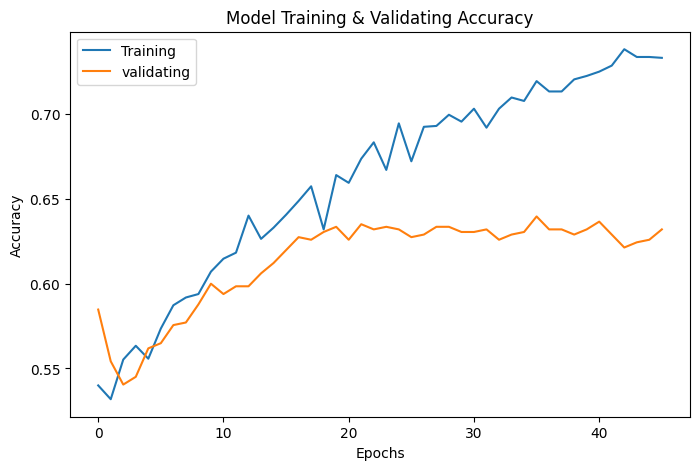

In [79]:
# Training History: Accuracy over Epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"], label="Training ")
plt.plot(history.history["val_accuracy"], label="validating")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Training & Validating Accuracy")
plt.legend()
plt.show()

## Model Evaluation

In [80]:
# 📌 Evaluate the Model on Training and Testing Data
train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)

# 📌 Print Evaluation Results
print("\n📊 **Model Performance Evaluation**")
print("-" * 40)
print(f"Training Loss: {train_loss:.3f}")
print(f"Testing Loss : {test_loss:.3f}")
print(f"Training Accuracy: {train_acc:.3f}")
print(f"Testing Accuracy : {test_acc:.3f}")


📊 **Model Performance Evaluation**
----------------------------------------
Training Loss: 0.606
Testing Loss : 0.736
Training Accuracy: 0.761
Testing Accuracy : 0.640


In [81]:
from sklearn.metrics import classification_report

# Predict probabilities
Y_probs = model.predict(X_test)

# Try different thresholds
for threshold in [0.4, 0.5, 0.6]:
    Y_pred = (Y_probs > threshold).astype("int32")  # Apply threshold
    print(f"\n📊 Classification Report for Threshold = {threshold}")
    print(classification_report(Y_test, Y_pred))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

📊 Classification Report for Threshold = 0.4
              precision    recall  f1-score   support

           0       0.77      0.46      0.58       399
           1       0.49      0.79      0.60       257

    accuracy                           0.59       656
   macro avg       0.63      0.63      0.59       656
weighted avg       0.66      0.59      0.59       656


📊 Classification Report for Threshold = 0.5
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       399
           1       0.54      0.62      0.57       257

    accuracy                           0.64       656
   macro avg       0.63      0.64      0.63       656
weighted avg       0.65      0.64      0.64       656


📊 Classification Report for Threshold = 0.6
              precision    recall  f1-score   support

           0       0.69      0.81      0.75       399
           1       0.60      0.43      0.50       257

    accu

In [82]:
history_dict = history.history
print(history_dict)

{'accuracy': [0.5399491190910339, 0.5318065881729126, 0.5552163124084473, 0.5633587837219238, 0.5557252168655396, 0.5735368728637695, 0.587277352809906, 0.5918574929237366, 0.5938931107521057, 0.6071246862411499, 0.6147582530975342, 0.6183205842971802, 0.6402035355567932, 0.6264631152153015, 0.6330788731575012, 0.6407124400138855, 0.6488549709320068, 0.6575063467025757, 0.6320610642433167, 0.6641221642494202, 0.6595419645309448, 0.6737913489341736, 0.683460533618927, 0.6671755909919739, 0.694656491279602, 0.6722646355628967, 0.6926208734512329, 0.6931297779083252, 0.6997455358505249, 0.6956743001937866, 0.7033078670501709, 0.6921119689941406, 0.7033078670501709, 0.7099236845970154, 0.7078880667686462, 0.7195928692817688, 0.7134860157966614, 0.7134860157966614, 0.7206106781959534, 0.7226462960243225, 0.7251908183097839, 0.7287532091140747, 0.7384223937988281, 0.7338422536849976, 0.7338422536849976, 0.7333333492279053], 'loss': [1.0624094009399414, 0.9619265198707581, 0.9062501788139343,

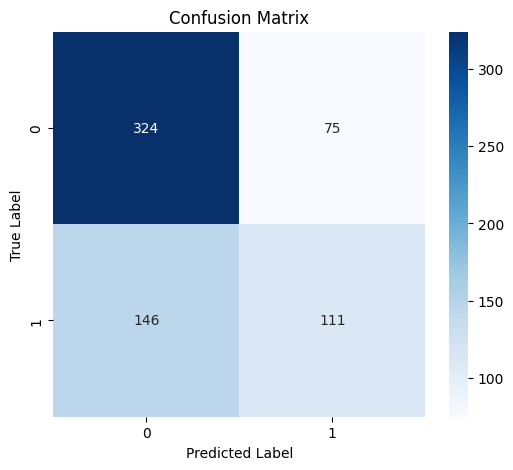

In [83]:
from sklearn.metrics import confusion_matrix


# 📌 Compute the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# 📌 Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [84]:
# 📌 Compute Additional Classification Metrics
Y_pred = (model.predict(X_test) > 0.5).astype("int32")

from sklearn.metrics import f1_score, recall_score, precision_score
f1 = f1_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [85]:
# Classification Report
print("Classification Report:")
print(classification_report(Y_test, Y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       399
           1       0.54      0.62      0.57       257

    accuracy                           0.64       656
   macro avg       0.63      0.64      0.63       656
weighted avg       0.65      0.64      0.64       656



In [86]:
# Print F1 Score, Recall, and Precision
f1 = f1_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
print(f"F1 Score: {f1}, Recall: {recall}, Precision: {precision}")

F1 Score: 0.5740072202166066, Recall: 0.6186770428015564, Precision: 0.5353535353535354


In [87]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 128)                 │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,485 (142.52 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 24,068 (94.02 KB)